# Homework 5 - Assigment 2

In this part of the homework, we are asked to perform sentiment analysis on every email message and infer Hillary Clinton's perception of the different world countries.

## import cleaned data

We will start by importing the pre-processed dataset, saved in the part 1 notebook.

In [1]:
# basic imports 
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import nltk
import pycountry
from nltk.sentiment import SentimentIntensityAnalyzer


# filenames
clean_emails_filename ='preprocessed_emails.csv'
clean_emails = pd.read_csv(clean_emails_filename,index_col = 0, header = 0).dropna(how='all')

In [2]:
clean_emails.columns = ['Email Text']
clean_emails = clean_emails.set_index(np.arange(clean_emails.shape[0]))
clean_emails.head()

,Email Text
0,wow
1,2011 945 latest syria aid qaddafi sid hrc memo...
2,chri steven thx
3,cairo condemn final
4,11 2011 136 huma abedin latest syria aid qadda...


## World Countries

First, we should find all the mentions of world countries in the whole corpus, using the pycountry utility.

We will start by investigating the pycountry utility.

In [3]:
print('Number of countries : {}.'.format(len(pycountry.countries)))

i = 0
for c in pycountry.countries:
    i = i+1
    print(c)
    if i>10:
        break

Number of countries : 249.
Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533')
Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan')
Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola')
Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660')
Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248')
Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania')
Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra')
Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784')
Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic')
Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia')
Country(alpha_2='AS', alpha_3='ASM

Each country has three relevent components for us, which are : alpha_2, alpha_3 and name. We will put all these elements in a list, indexed by the coutries names.

In [4]:
countries = {}

for country in pycountry.countries:
    countries[country.name] = [country.name.lower(), country.alpha_2.lower(), country.alpha_3.lower()]
    
countries

{'Afghanistan': ['afghanistan', 'af', 'afg'],
 'Albania': ['albania', 'al', 'alb'],
 'Algeria': ['algeria', 'dz', 'dza'],
 'American Samoa': ['american samoa', 'as', 'asm'],
 'Andorra': ['andorra', 'ad', 'and'],
 'Angola': ['angola', 'ao', 'ago'],
 'Anguilla': ['anguilla', 'ai', 'aia'],
 'Antarctica': ['antarctica', 'aq', 'ata'],
 'Antigua and Barbuda': ['antigua and barbuda', 'ag', 'atg'],
 'Argentina': ['argentina', 'ar', 'arg'],
 'Armenia': ['armenia', 'am', 'arm'],
 'Aruba': ['aruba', 'aw', 'abw'],
 'Australia': ['australia', 'au', 'aus'],
 'Austria': ['austria', 'at', 'aut'],
 'Azerbaijan': ['azerbaijan', 'az', 'aze'],
 'Bahamas': ['bahamas', 'bs', 'bhs'],
 'Bahrain': ['bahrain', 'bh', 'bhr'],
 'Bangladesh': ['bangladesh', 'bd', 'bgd'],
 'Barbados': ['barbados', 'bb', 'brb'],
 'Belarus': ['belarus', 'by', 'blr'],
 'Belgium': ['belgium', 'be', 'bel'],
 'Belize': ['belize', 'bz', 'blz'],
 'Benin': ['benin', 'bj', 'ben'],
 'Bermuda': ['bermuda', 'bm', 'bmu'],
 'Bhutan': ['bhutan', 'b

We will now write a function that takes a string data and countries names and returns a list of the mentionned countries in the data, and then try it on one single email.

In [5]:
def country_mentions(mail,countries):
    mentionned_countries = []
    tokens = set(nltk.word_tokenize(mail))
    for country, names in countries.items():
        if not tokens.isdisjoint(set(names)):
            mentionned_countries.append(country)
    return mentionned_countries

In [6]:
country_mentions(clean_emails.iloc[20,0],countries)

['Libya']

We will apply the function above on all the emails, and concatenate the results with the data frame.

In [7]:
mentionned_countries = {}

for i in np.arange(clean_emails.shape[0]): 
    mail = clean_emails.iloc[i,0]
    mentionned_countries[i] =  country_mentions(mail,countries)

mentionned_countries = pd.Series(mentionned_countries)
clean_emails['Countries'] = mentionned_countries
clean_emails.head()

,Email Text,Countries
0,wow,[]
1,2011 945 latest syria aid qaddafi sid hrc memo...,[Libya]
2,chri steven thx,[]
3,cairo condemn final,[]
4,11 2011 136 huma abedin latest syria aid qadda...,[Libya]


It is now important to filter the dataframe in order to keep only the emails in which at least one country is mentionned.

In [8]:
print('Number of emails : {}.'.format(clean_emails.shape[0]))
# suppress emails without any country mention
clean_emails = clean_emails[[(countries != []) for countries in clean_emails['Countries']]]
print('Number of emails with coutries\' mentions: {}.'.format(clean_emails.shape[0]))
clean_emails = clean_emails.set_index(np.arange(clean_emails.shape[0]))
clean_emails.head()

Number of emails : 7510.
Number of emails with coutries' mentions: 2752.


,Email Text,Countries
0,2011 945 latest syria aid qaddafi sid hrc memo...,[Libya]
1,11 2011 136 huma abedin latest syria aid qadda...,[Libya]
2,right wing extremist behind antimuslim film sp...,[United States]
3,antimuslim film director hide follow libya egy...,"[Egypt, Libya]"
4,11 2011 136 huma abedin latest syria aid qadda...,[Libya]


## Sentiment analysis - Vader_analyzer

We will now perform sentiment analysis on every email message using the demo method 'Vader_analyzer' in the nltk.sentiment.util module.

In [9]:
vader_analyzer = SentimentIntensityAnalyzer()

sentiments = {}

for i in np.arange(clean_emails.shape[0]): 
    mail = clean_emails.iloc[i,0]
    score = vader_analyzer.polarity_scores(mail)['compound']
    sentiments[i] = score
            
sentiments = pd.Series(sentiments)
clean_emails['Polarity'] = sentiments
clean_emails.head()

,Email Text,Countries,Polarity
0,2011 945 latest syria aid qaddafi sid hrc memo...,[Libya],0.0000
1,11 2011 136 huma abedin latest syria aid qadda...,[Libya],0.0000
2,right wing extremist behind antimuslim film sp...,[United States],-0.5994
3,antimuslim film director hide follow libya egy...,"[Egypt, Libya]",-0.1779
4,11 2011 136 huma abedin latest syria aid qadda...,[Libya],0.0000


## Countries' perception

### Aggregation

We will now aggregate the polarity information of all the emails by country.
We will start by expanding each element in the 'Countries' column into multiple rows :

In [10]:
rows = []
_ = clean_emails.apply(lambda row: [rows.append([row['Email Text'], nn, row['Polarity']]) 
                         for nn in row.Countries], axis=1)
clean_emails_new = pd.DataFrame(rows, columns=clean_emails.columns)

In [11]:
clean_emails_new.head()

,Email Text,Countries,Polarity
0,2011 945 latest syria aid qaddafi sid hrc memo...,Libya,0.0000
1,11 2011 136 huma abedin latest syria aid qadda...,Libya,0.0000
2,right wing extremist behind antimuslim film sp...,United States,-0.5994
3,antimuslim film director hide follow libya egy...,Egypt,-0.1779
4,antimuslim film director hide follow libya egy...,Libya,-0.1779


We will now take only the 'Countries' and 'Polarity' columns.

In [12]:
countries_polarity = clean_emails_new[['Countries', 'Polarity']]
countries_polarity.head()

,Countries,Polarity
0,Libya,0.0000
1,Libya,0.0000
2,United States,-0.5994
3,Egypt,-0.1779
4,Libya,-0.1779


For each country, we will take the mean of all polarities as the global perception.

In [13]:
countries_polarity = countries_polarity.groupby('Countries').agg('mean').sort_values('Polarity')
countries_polarity.head()

,Polarity
Countries,
Latvia,-0.979600
Bermuda,-0.646267
Vanuatu,-0.618150
Syrian Arab Republic,-0.383950
Gibraltar,-0.373900


### Plotting the results

We will now plot a histogram, ordered and colored by polarity level, that summarizes the perception of the different countries.

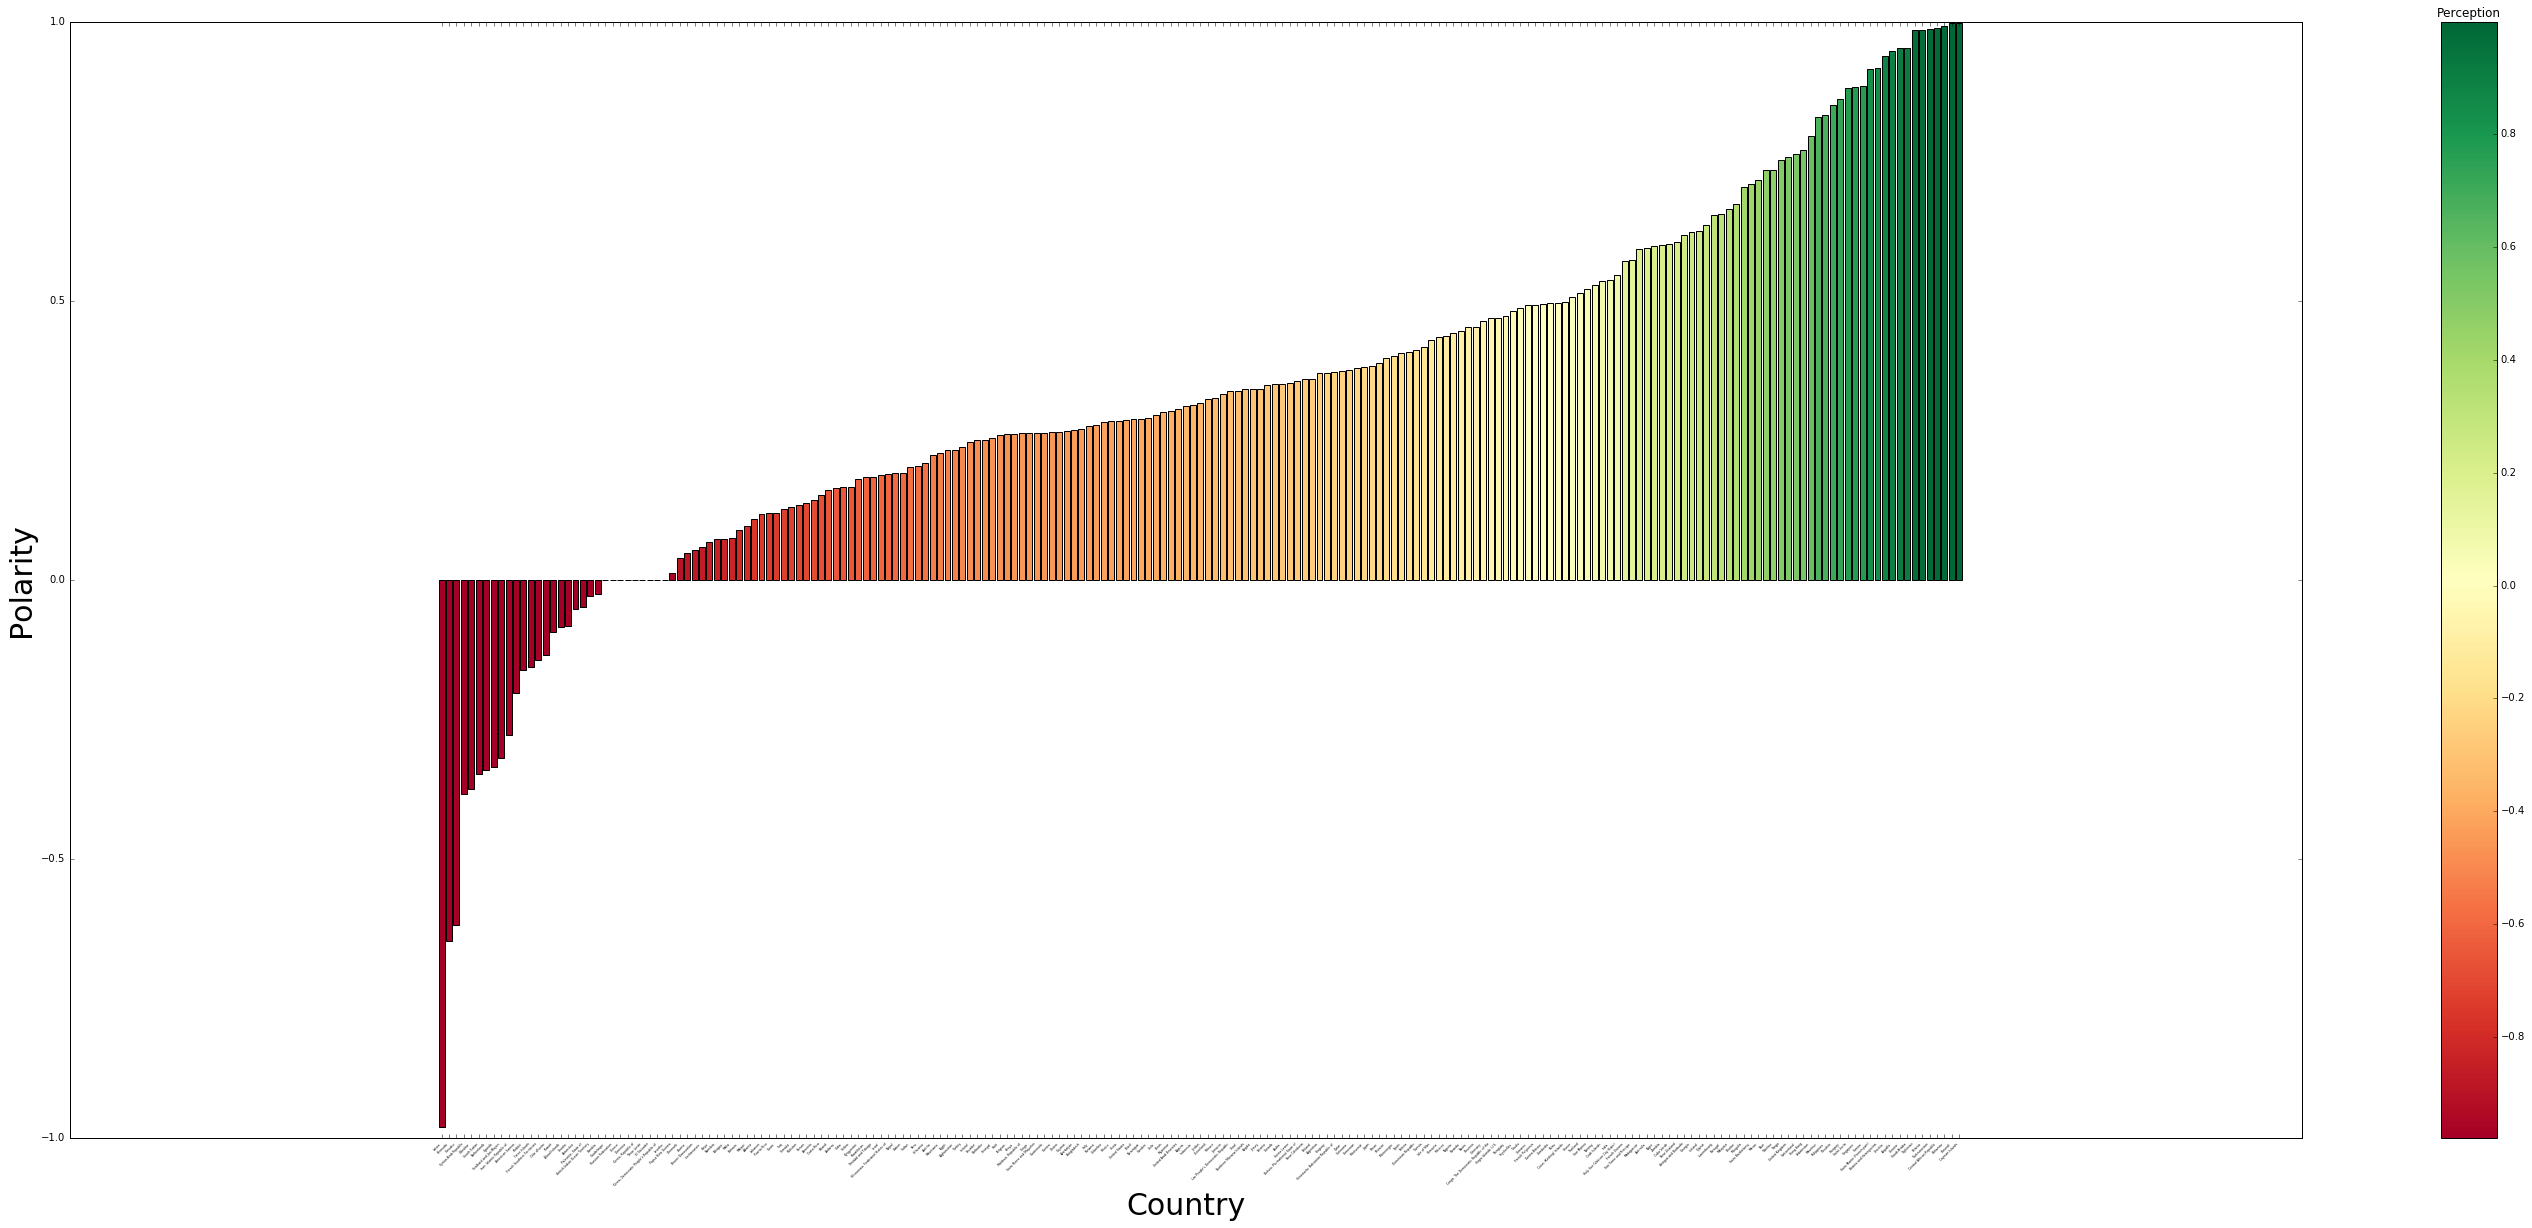

In [14]:
# Set up colors : red to green
plt.figure(figsize = (50,20))
y = np.array(countries_polarity['Polarity'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Perception")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(countries_polarity.shape[0]), countries_polarity['Polarity'], align='center', tick_label=countries_polarity.index, color=colors)
plt.xticks(rotation=45, ha='right',fontsize = 3)
plt.xlabel("Country",fontsize = 30)
plt.ylabel("Polarity",fontsize = 30)
plt.show()

To make the results more visible, we will show them part by part.

In [15]:
# Countries with negative polarity only
neg_polarity = countries_polarity[countries_polarity.Polarity<=0]
neg_polarity.head()

,Polarity
Countries,
Latvia,-0.979600
Bermuda,-0.646267
Vanuatu,-0.618150
Syrian Arab Republic,-0.383950
Gibraltar,-0.373900


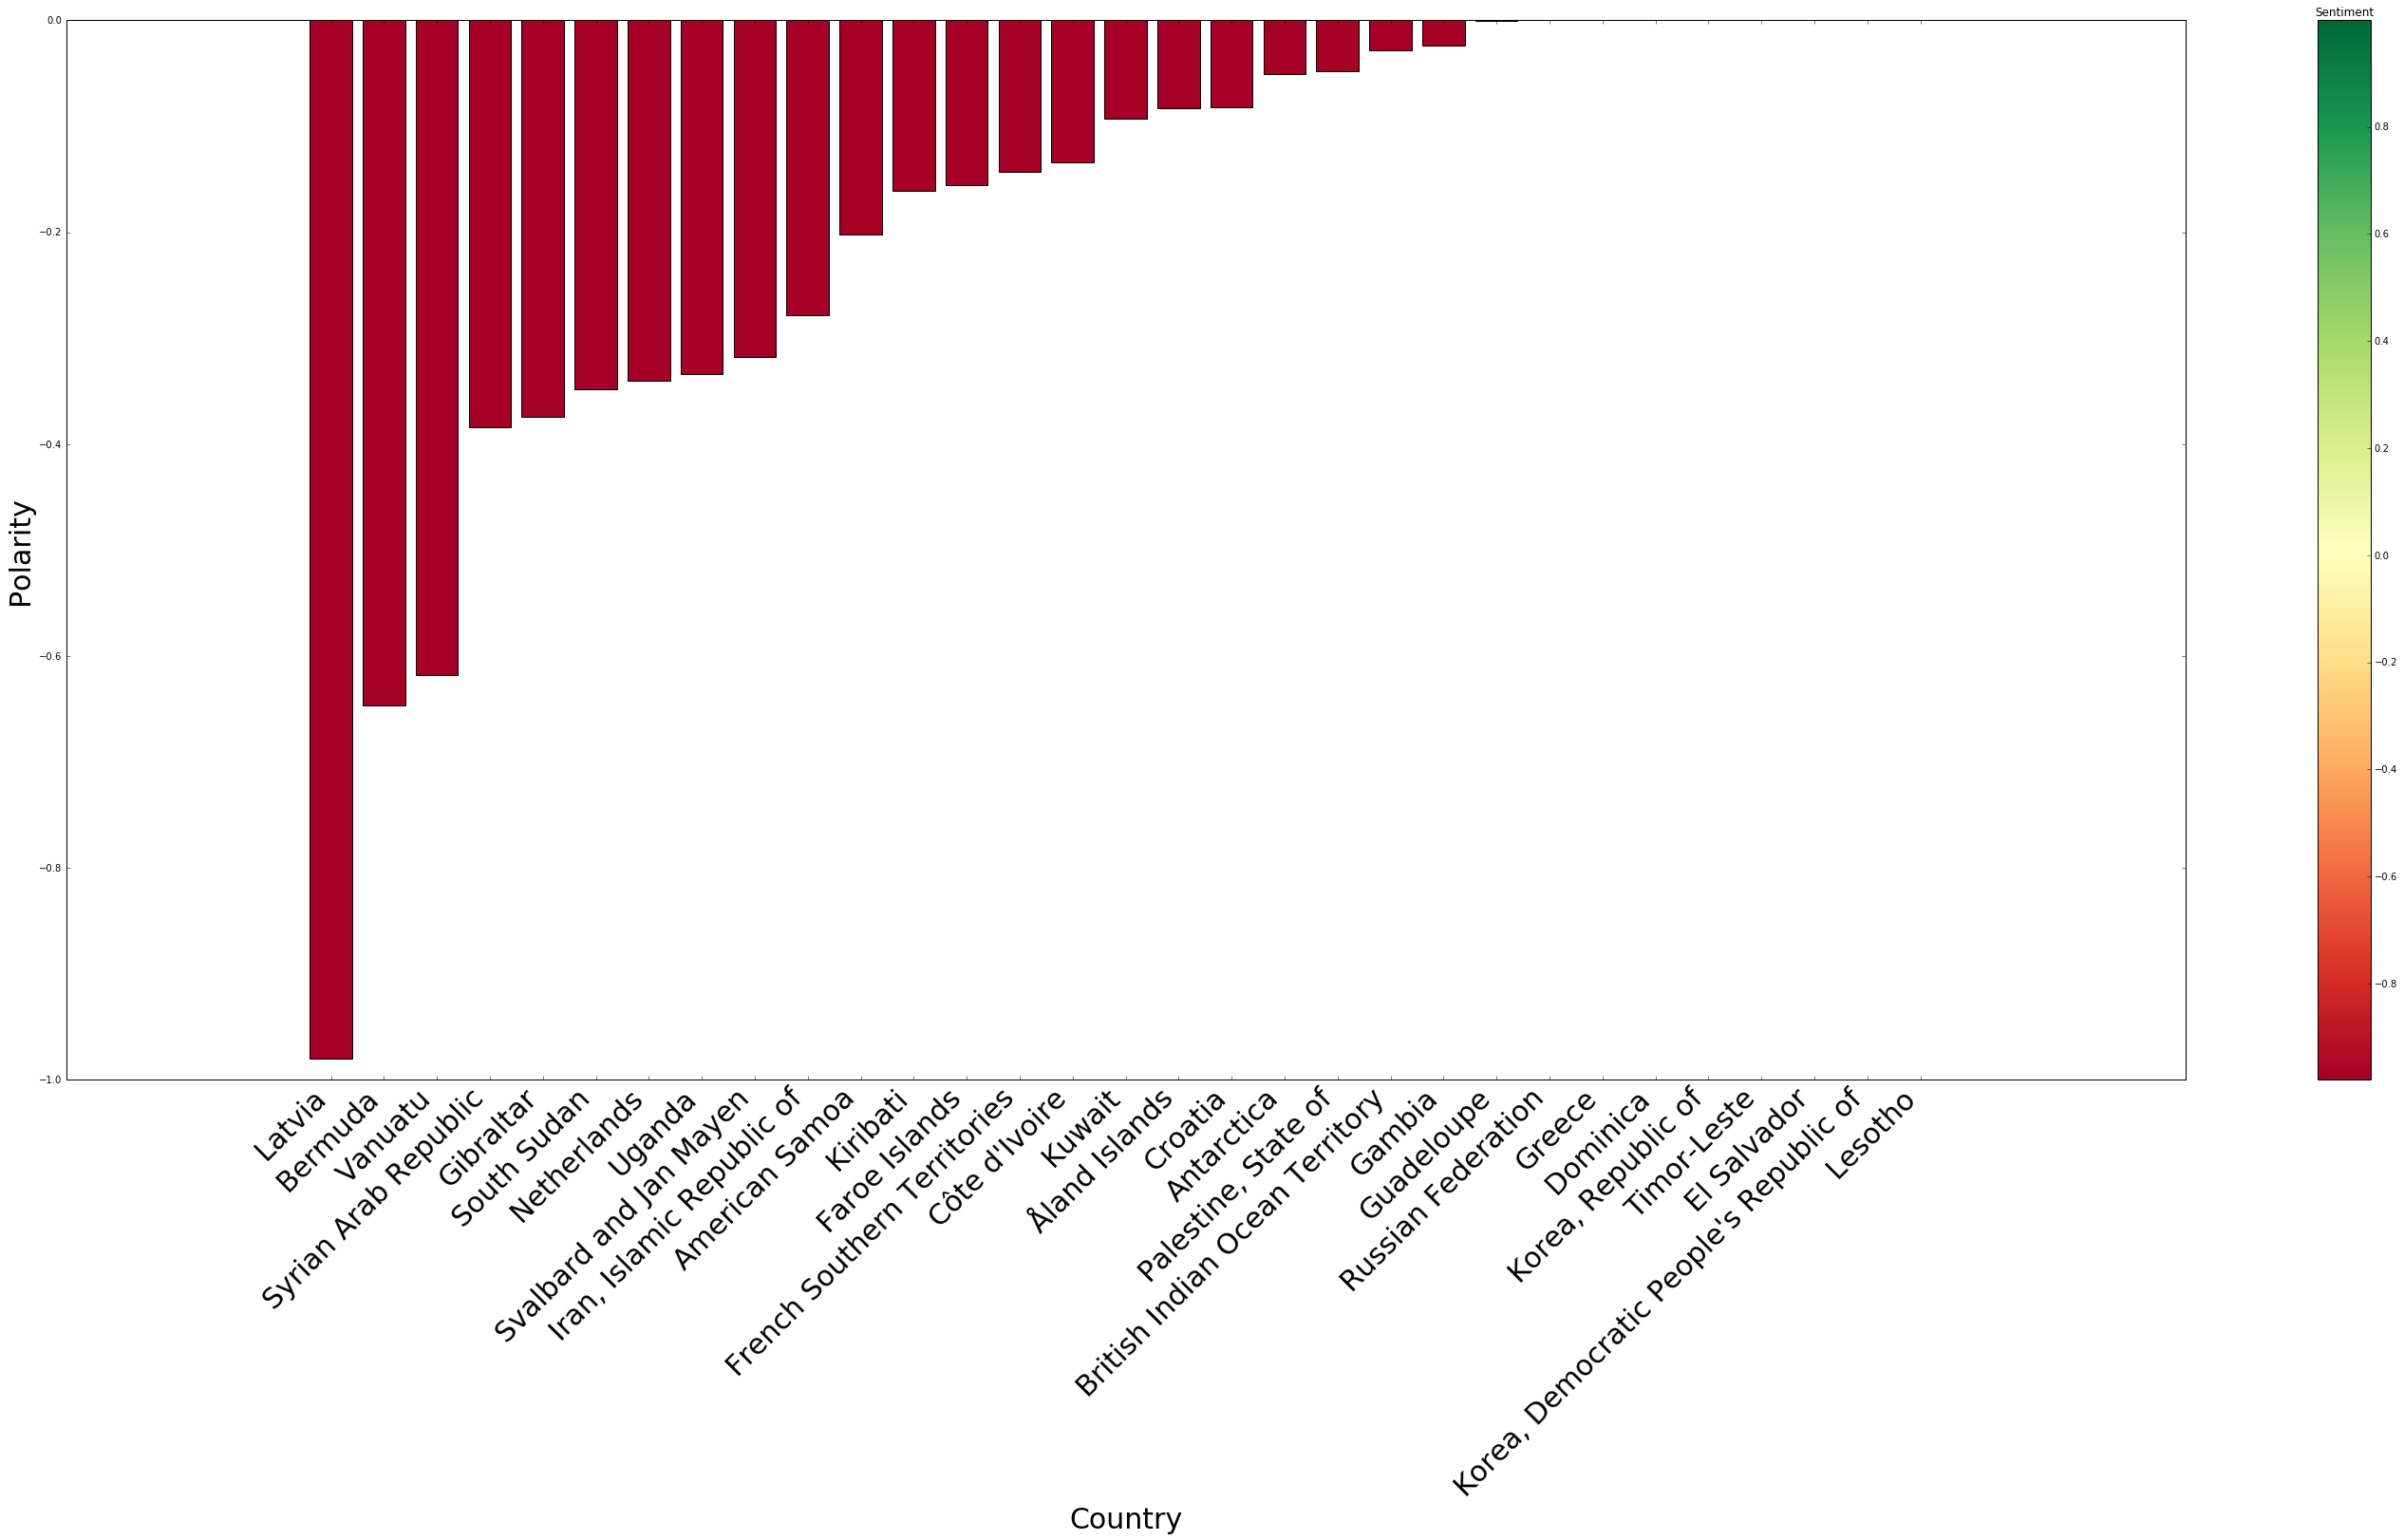

In [16]:
plt.figure(figsize = (50,20))
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

plt.bar(range(neg_polarity.shape[0]), neg_polarity['Polarity'], align='center', tick_label=neg_polarity.index, color=colors)
plt.xticks(rotation=45, ha='right',fontsize = 30)
plt.xlabel("Country",fontsize = 30)
plt.ylabel("Polarity",fontsize = 30)
plt.show()

In [17]:
# Countries with positive perception
pos_polarity = countries_polarity[countries_polarity.Polarity>0]
pos_polarity.head()

,Polarity
Countries,
Papua New Guinea,0.012033
Denmark,0.040450
Liberia,0.049444
Brunei Darussalam,0.053286
Liechtenstein,0.059355


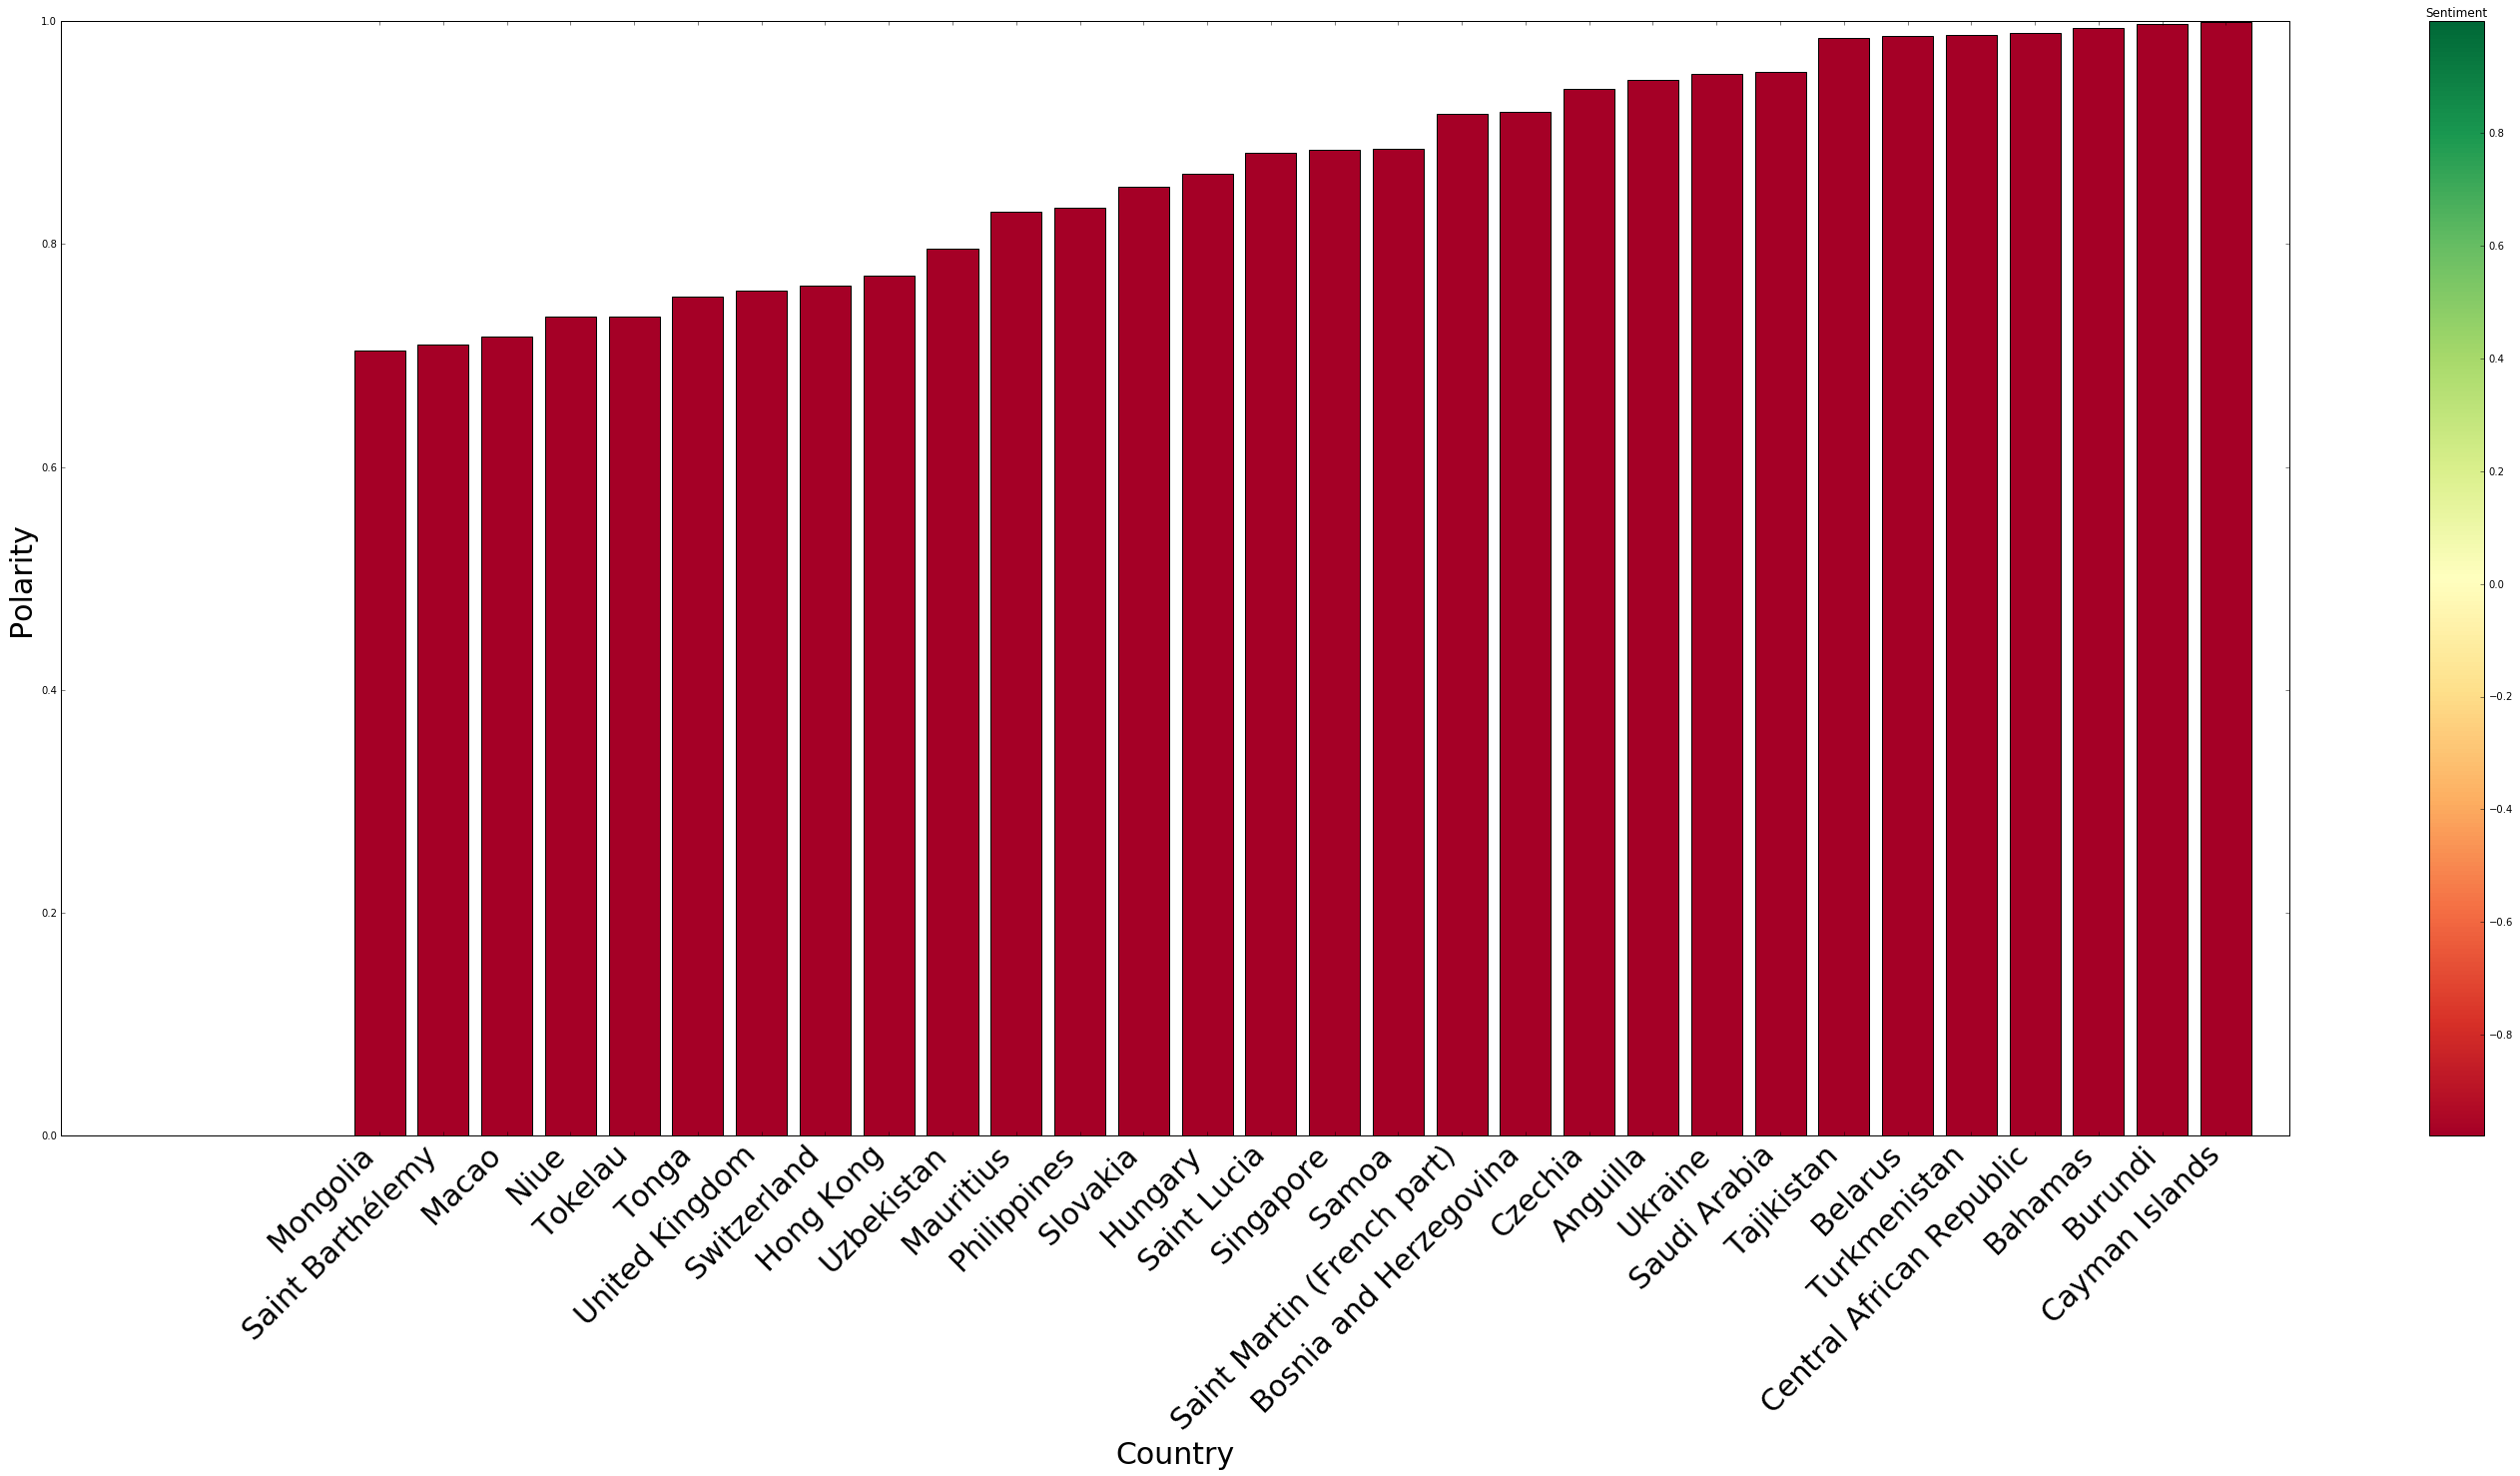

In [18]:
plt.figure(figsize = (50,20))
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

plt.bar(range(pos_polarity[-30:].shape[0]), pos_polarity[-30:]['Polarity'], align='center', tick_label=pos_polarity[-30:].index, color=colors)
plt.xticks(rotation=45, ha='right',fontsize = 30)
plt.xlabel("Country",fontsize = 30)
plt.ylabel("Polarity",fontsize = 30)
plt.show()

## Other methods

We will now repeat the aggregation and the plotting steps using a different demo method from the sentiment analysis module, which is the liu_hu_lexicon method.

We will start by writing a function and applying it on one single email.

In [21]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank

tokenizer = treebank.TreebankWordTokenizer()

def liu_hu_lexicon_polarity(mail,tokenizer):
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(mail)]

    word_polarities = []

    for word in tokenized_sent:
            if word in opinion_lexicon.positive():
                pos_words += 1
                word_polarities.append(1) # positive
            elif word in opinion_lexicon.negative():
                neg_words += 1
                word_polarities.append(-1) # negative
            else:
                word_polarities.append(0) # neutral

    polarity_score = np.mean(word_polarities)
    return polarity_score

mail = clean_emails.iloc[4,0]

liu_hu_lexicon_polarity(mail,tokenizer)

0.0

We will now apply the polarity function on all the emails.

In [27]:
sentiments2 = {}

for i in np.arange(clean_emails.shape[0]): 
    mail = clean_emails.iloc[i,0]
    sentiments2[i] = liu_hu_lexicon_polarity(mail,tokenizer)
    # verbose
    if i % 100 == 0:
        print('email No {}'.format(i+1))
            
sentiments2 = pd.Series(sentiments2)
clean_emails['Polarity 2'] = sentiments2
clean_emails.head()

email No 1
email No 101
email No 201
email No 301
email No 401
email No 501
email No 601
email No 701
email No 801
email No 901
email No 1001
email No 1101
email No 1201
email No 1301
email No 1401
email No 1501
email No 1601
email No 1701
email No 1801
email No 1901
email No 2001
email No 2101
email No 2201
email No 2301
email No 2401
email No 2501
email No 2601
email No 2701


,Email Text,Countries,Polarity,Polarity 2
0,2011 945 latest syria aid qaddafi sid hrc memo...,[Libya],0.0000,0.000000
1,11 2011 136 huma abedin latest syria aid qadda...,[Libya],0.0000,0.000000
2,right wing extremist behind antimuslim film sp...,[United States],-0.5994,-0.013699
3,antimuslim film director hide follow libya egy...,"[Egypt, Libya]",-0.1779,0.000000
4,11 2011 136 huma abedin latest syria aid qadda...,[Libya],0.0000,0.000000


We will now aggregate and plot the results.

In [29]:
rows = []
_ = clean_emails.apply(lambda row: [rows.append([row['Email Text'], nn, row['Polarity 2']]) 
                         for nn in row.Countries], axis=1)
clean_emails_new = pd.DataFrame(rows, columns=['Email Text','Countries','Polarity'])
countries_polarity2 = clean_emails_new[['Countries', 'Polarity']]

countries_polarity2.head()

,Countries,Polarity
0,Libya,0.000000
1,Libya,0.000000
2,United States,-0.013699
3,Egypt,0.000000
4,Libya,0.000000


In [38]:
countries_polarity2 = countries_polarity2.groupby('Countries').agg('mean').sort_values('Polarity')
countries_polarity2.head()

,Polarity
Countries,
Nepal,-0.083333
Uganda,-0.073223
Liberia,-0.053491
Syrian Arab Republic,-0.050790
Côte d'Ivoire,-0.041281


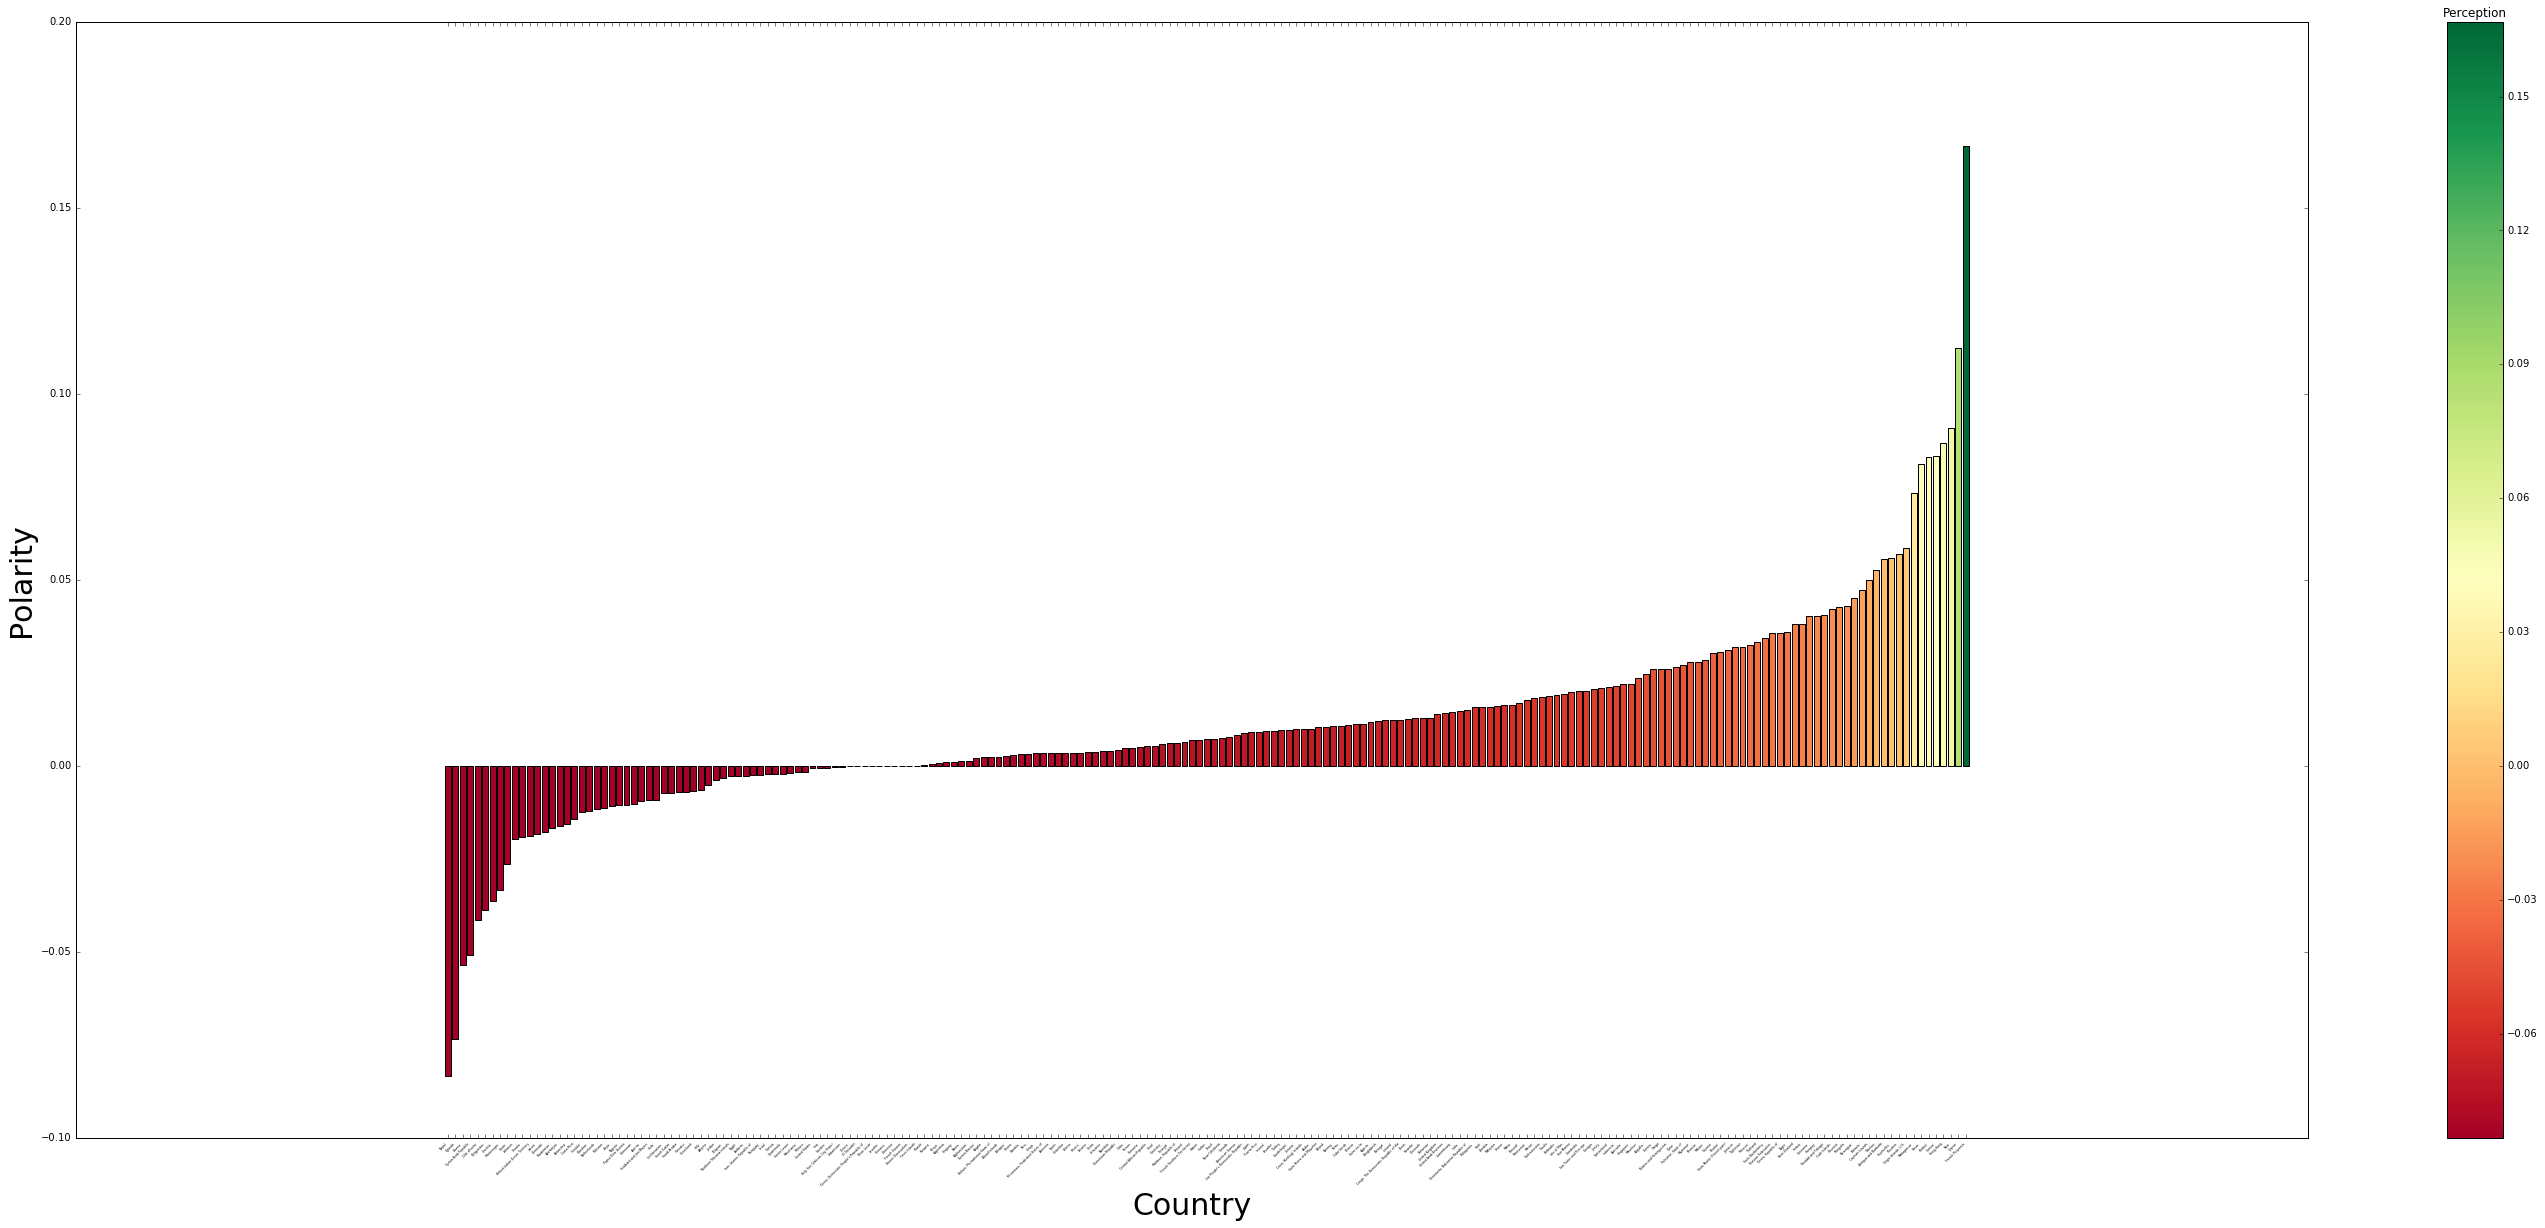

In [39]:
# Set up colors : red to green
plt.figure(figsize = (50,20))
y = np.array(countries_polarity2['Polarity'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Perception")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(countries_polarity2.shape[0]), countries_polarity2['Polarity'], align='center', tick_label=countries_polarity2.index, color=colors)
plt.xticks(rotation=45, ha='right',fontsize = 3)
plt.xlabel("Country",fontsize = 30)
plt.ylabel("Polarity",fontsize = 30)
plt.show()

We will now try to make more visible plots, as we did for the first plot.

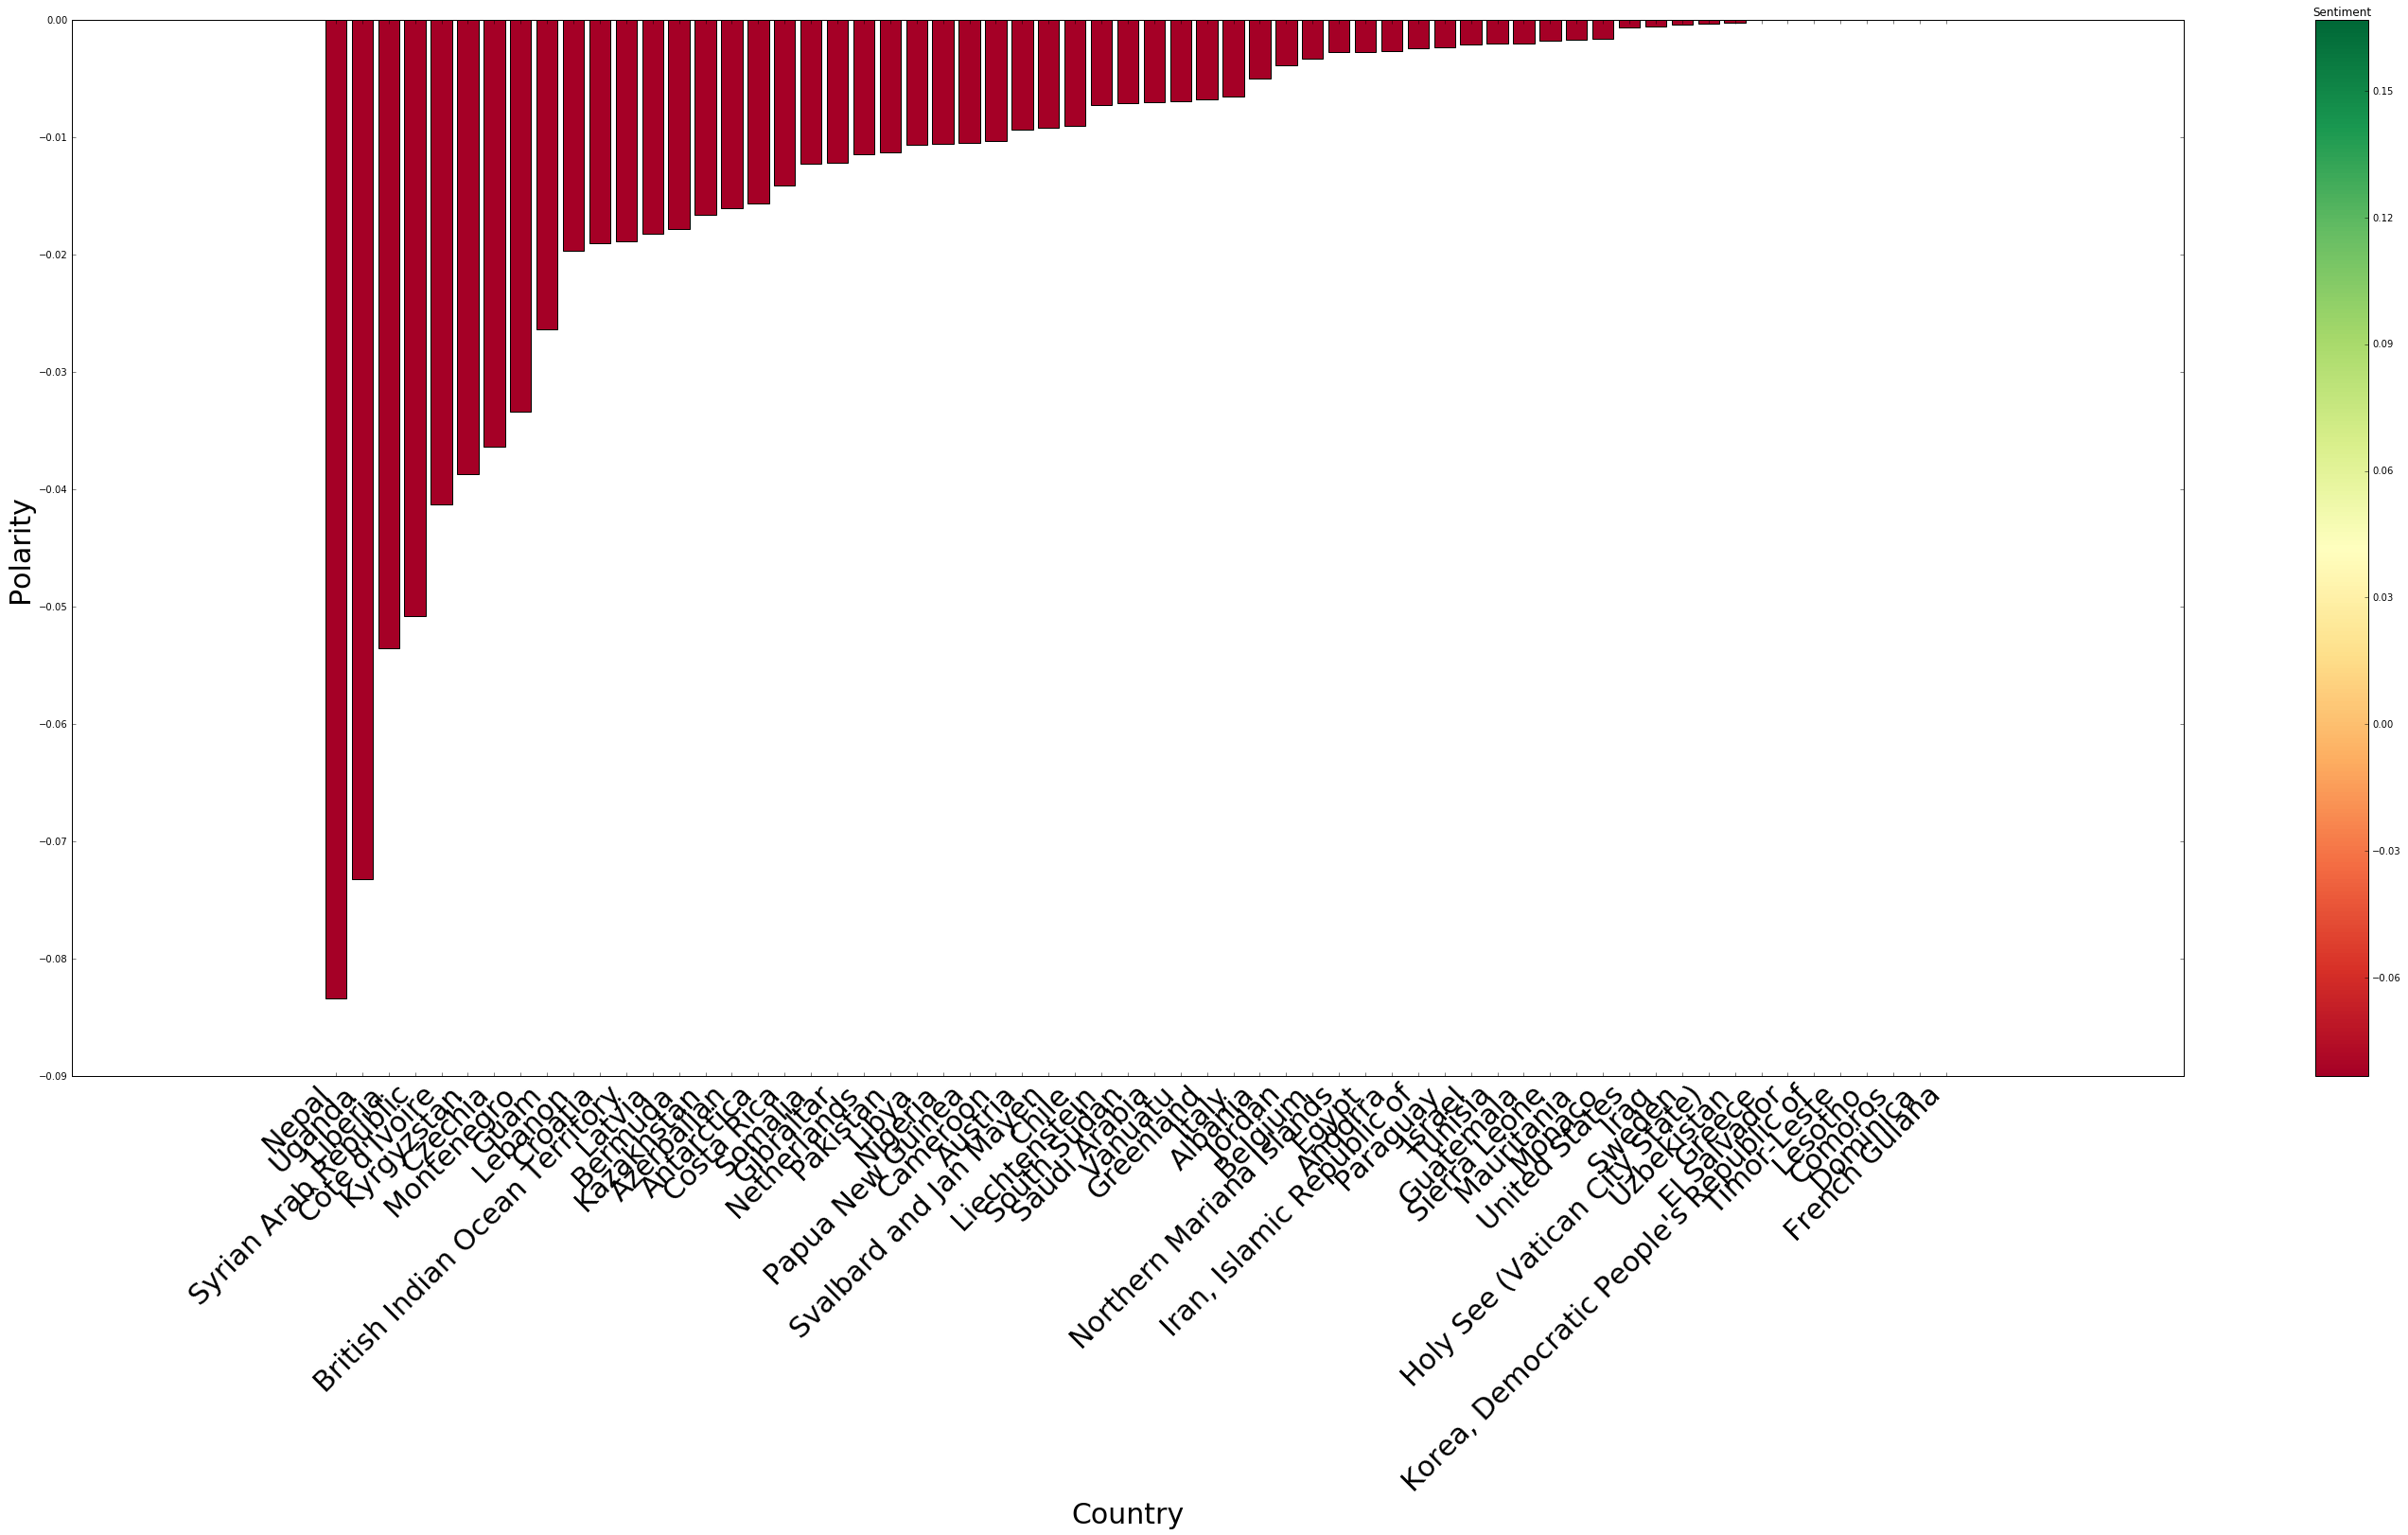

In [40]:
plt.figure(figsize = (50,20))
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Countries with negative polarity only
neg_polarity = countries_polarity2[countries_polarity2.Polarity<=0]
neg_polarity.head()

plt.bar(range(neg_polarity.shape[0]), neg_polarity['Polarity'], align='center', tick_label=neg_polarity.index, color=colors)
plt.xticks(rotation=45, ha='right',fontsize = 30)
plt.xlabel("Country",fontsize = 30)
plt.ylabel("Polarity",fontsize = 30)
plt.show()

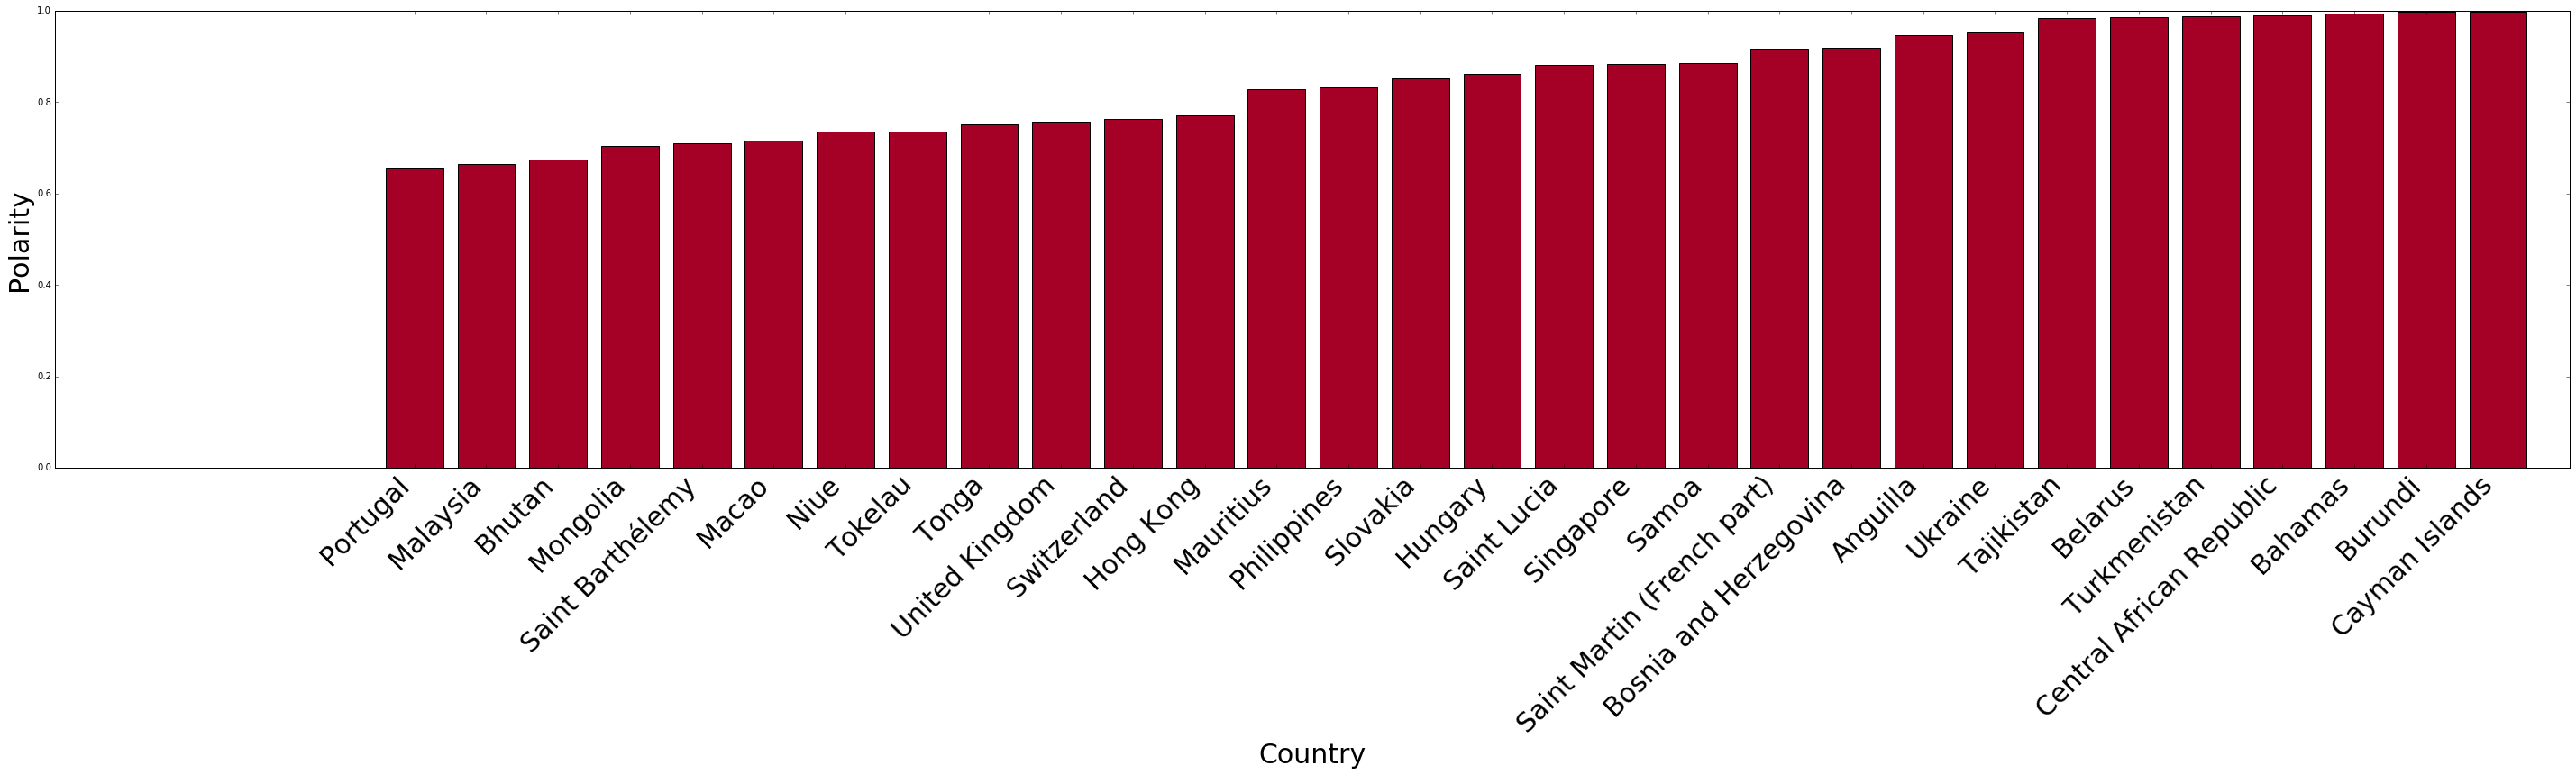

In [41]:
plt.figure(figsize = (50,20))
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Countries with positive perception
pos_polarity = countries_polarity[countries_polarity2.Polarity>0]
pos_polarity.head()

plt.subplot(211)

plt.bar(range(pos_polarity[-30:].shape[0]), pos_polarity[-30:]['Polarity'], align='center', tick_label=pos_polarity[-30:].index, color=colors)
plt.xticks(rotation=45, ha='right',fontsize = 30)
plt.xlabel("Country",fontsize = 30)
plt.ylabel("Polarity",fontsize = 30)
plt.show()

### Comparison

    We notice that more countries have a negative perception with the second analyzer.
    The order of some coutries after sorting polarity values did not change to much. While we notice a big difference for some coutries (example : Nepal)